<a href="https://colab.research.google.com/github/MartinGerini/Ambient-Intelligence/blob/main/DIFFUSIONMODEL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**SMOTE vs DIFFUSION MODEL for Sensor-Based HAR data augmentation**

In this notebook, we are going to train a Convolutional Neural Network for a Human Activity Recognition task making use of two different data augmentation techiques: **SMOTE** and **Diffusion Model**.

At first, we will take a look at the data from the HARTH dataset, in order to decide what kind of pre-processing techniques to use. Subsequently, we will clean the data with these techniques and apply a segmentation to get windows of accelerometer data with 3 channels (x, y, z). We will then look at these windows, focusing on their unbalanced labels. Next, we will define the CNN we will be using as a classifier.

Finally we will dive into the data augmentation:


*   We will train our neural network exploiting the **SMOTE** data augmentation technique and test it through a *LOSO* validation strategy. In particular, we will exploit 2 different ways to apply SMOTE: an *inter-subject* SMOTE and an *intra-subject* SMOTE augmentation. In the former, we will apply SMOTE to the whole train set; in the latter, the augmentation will be applied to each train subject separately.
*   We will create our **Diffusion Model**, by implementing the forward diffusion process, designing and training the U-Net architecture and lastly defining the reverse process, through which we will be able to generate synthetic data. Finally, we will train and test our classifier exploiting the data augmentation of the Diffusion Model. Hence again, *LOSO* validation strategy will be used.



# Brief overview of data

In [ ]:
# Let's import the first libraries we'll need
import pandas as pd
from datetime import datetime
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import tensorflow as tf

# Let's use GPU!
if tf.config.list_physical_devices('GPU'):
    device = '/GPU:0'
    print("GPU available, using GPU.")
else:
    device = '/CPU:0'
    print("No GPU available, using CPU instead.")


GPU available, using GPU.


In [ ]:
# I have the data on my Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
single_df = pd.read_csv(f"/content/drive/MyDrive/machine learning/Ambient/harth/S09.csv", sep=',', header=None, engine='python')
single_df.head() # let's have a look

,0,1,2,3,4,5,6,7,8
0,timestamp,index,back_x,back_y,back_z,thigh_x,thigh_y,thigh_z,label
1,2019-01-12 00:00:00.000,0,-0.9994919623286432,0.0231915875680036,0.0254609911984683,-0.9359646909072608,0.0239794725440041,-0.3555212402899143,6
2,2019-01-12 00:00:00.020,1,-0.9955513735346052,0.0214143872946635,0.0422970762403743,-0.9288753941393711,0.0295404928538126,-0.3711511573964186,6
3,2019-01-12 00:00:00.040,2,-0.9895071337301632,0.0121870589390843,0.0388302281775195,-0.9429068413780382,0.0196767283547306,-0.3596486362762905,6
4,2019-01-12 00:00:00.060,3,-0.9913273042130994,0.0159258248480584,0.0561808893891283,-0.9423632331366776,0.0096822856321589,-0.3489160227076153,6


In [ ]:
# We need to get rid of that first row
single_df = single_df.drop(0)
single_df.columns = ['timestamp', 'acc_x_back', 'acc_y_back', 'acc_z_back', 'acc_x_thigh', 'acc_y_thigh', 'acc_z_thigh', 'label']
single_df

,timestamp,acc_x_back,acc_y_back,acc_z_back,acc_x_thigh,acc_y_thigh,acc_z_thigh,label
1,2019-01-12 00:00:00.000,-0.7602415495758507,0.2995702077922794,0.4685697585421129,-5.092731893159047,-0.2986439462890465,0.7094393132553707,6
2,2019-01-12 00:00:00.010,-0.5301384612971402,0.2818800455400766,0.3199869592000484,0.9005472945185086,0.2869438209726433,0.3403088175851045,6
3,2019-01-12 00:00:00.020,-1.170921965312795,0.1863529365957872,-0.1670098008163029,-0.0354421048355582,-0.0784234072394277,-0.5152121964956222,6
4,2019-01-12 00:00:00.030,-0.6487717053834511,0.0165787494914686,-0.0542838130257472,-1.5542484353902712,-0.9509776755325698,-0.2211403085585146,6
5,2019-01-12 00:00:00.040,-0.3550710244586012,-0.0518309832455381,-0.1134186861474665,-0.5474707818697858,0.140903166334082,-0.6537820571556622,6
...,...,...,...,...,...,...,...,...
408705,2019-01-12 01:09:32.880,-0.6904170606912825,0.0357100922061383,-0.6970544672422029,0.2282606104225667,0.0729500359478658,0.9851754892550808,7
408706,2019-01-12 01:09:32.890,-0.7452703889361534,0.032438272768901,-0.6813200979033529,-0.1219859959585453,0.0636995411636788,1.026664893323736,7
408707,2019-01-12 01:09:32.900,-0.6848268950166618,0.0376217546819623,-0.7038844432531368,0.3029599891489177,0.0769863714604846,0.978312942407342,7
408708,2019-01-12 01:09:32.910,-0.7515182814046811,0.0288185564876427,-0.6680371660145682,-0.2418033647566145,0.0566752422316665,1.0261663727489312,7


In [ ]:
print(single_df.dtypes) # let's see the types of the variables

timestamp       object
acc_x_back     float64
acc_y_back     float64
acc_z_back     float64
acc_x_thigh    float64
acc_y_thigh    float64
acc_z_thigh    float64
label           object
dtype: object


In [ ]:
# let's change the type of the variables!
single_df['acc_x_back'] = pd.to_numeric(single_df['acc_x_back'], errors='coerce')
single_df['acc_y_back'] = pd.to_numeric(single_df['acc_y_back'], errors='coerce')
single_df['acc_z_back'] = pd.to_numeric(single_df['acc_z_back'], errors='coerce')
single_df['acc_x_thigh'] = pd.to_numeric(single_df['acc_x_thigh'], errors='coerce')
single_df['acc_y_thigh'] = pd.to_numeric(single_df['acc_y_thigh'], errors='coerce')
single_df['acc_z_thigh'] = pd.to_numeric(single_df['acc_z_thigh'], errors='coerce')


In [ ]:
single_df.isnull().any().any() #checking for null values

False

<ipython-input-15-29f24f87c29b>:2: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  tmp_df["acc_y_back"].rolling(window=3, center=True, win_type='gaussian').mean(std=1).fillna(method="backfill").fillna(method="ffill").plot()


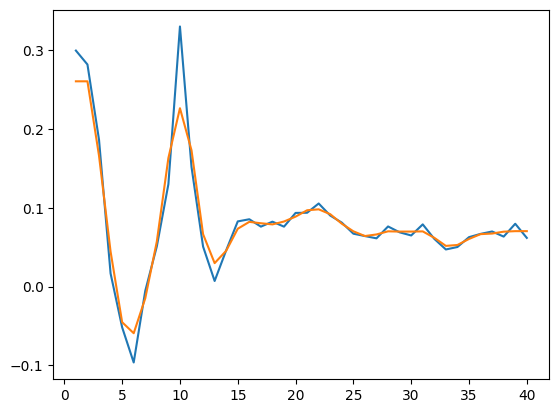

In [ ]:
# let's now look for a good filter to clean our data!
sns.set(rc={'figure.figsize':(15,5)})
starting_index = 0
window_len = 40 # 5 sec of data
tmp_df = single_df.iloc[starting_index:starting_index+window_len]

tmp_df["acc_y_back"].plot()
tmp_df["acc_y_back"].rolling(window=3, center=True, win_type='gaussian').mean(std=1).fillna(method="backfill").fillna(method="ffill").plot()
plt.show()

# Data Cleaning

We are now going to actually import and clean our dataset, subject by subject, using the filter we've seen works well with our data.
Moreover, by looking at the single subject data, I discovered the following issues we need to solve:


*   Subjects 15, 21 and 23 have an additional column named "Index". 15 and 21 have it placed as first column, while 23 got it placed as second column.
*   Subject 8 is the only subject having a sampling frequency of 100Hz, while the data from all the other subjects were taken at 50Hz. We will need then to downsample the data for subject 8.



In [ ]:
import pandas as pd

df = pd.DataFrame()

for subject in list(range(8, 30)):
  print(f"Subject {subject}")

  print("\tCreating the dataframe...")
  single_df = pd.read_csv(f"/content/drive/MyDrive/machine learning/Ambient/harth/S0{subject}.csv", sep=',', header=0, engine='python') # header = 0 to get rid of the first row

  if subject == 15 or subject == 21: # subjects 15 and 21 has an additional column "Index"
    print("\tRemoving Index column...")
    single_df = single_df.drop(single_df.columns[1], axis=1)
  elif subject == 23: # subject 23 has an additional column "Index"
    print("\tRemoving Index column...")
    single_df = single_df.drop(single_df.columns[0], axis=1)

  single_df.columns = ['timestamp', 'acc_x_back', 'acc_y_back', 'acc_z_back', 'acc_x_thigh', 'acc_y_thigh', 'acc_z_thigh', 'label']
  single_df['subject_id'] = subject

  if subject == 8: # subject 8 has sampling freq = 100 Hz, needs to be downsampled
    print("\tDownsampling Subject 8...")
    now = datetime.now()
    ts = datetime.timestamp(now)
    single_df['abs_datetime'] = pd.to_datetime(single_df['timestamp'])
    single_df = single_df.set_index('abs_datetime')
    single_df = single_df.resample('20L').bfill().ffill()
    single_df = single_df.reset_index(drop=False)
    single_df = single_df.drop('abs_datetime', axis=1)

  print("\tRemoving outliers...\n")
  single_df["acc_x_back"] = single_df["acc_x_back"].rolling(window=3, center=True, win_type='gaussian').mean(std=1).fillna(method="backfill").fillna(method="ffill")
  single_df["acc_y_back"] = single_df["acc_y_back"].rolling(window=3, center=True, win_type='gaussian').mean(std=1).fillna(method="backfill").fillna(method="ffill")
  single_df["acc_z_back"] = single_df["acc_z_back"].rolling(window=3, center=True, win_type='gaussian').mean(std=1).fillna(method="backfill").fillna(method="ffill")
  single_df["acc_x_thigh"] = single_df["acc_x_thigh"].rolling(window=3, center=True, win_type='gaussian').mean(std=1).fillna(method="backfill").fillna(method="ffill")
  single_df["acc_y_thigh"] = single_df["acc_y_thigh"].rolling(window=3, center=True, win_type='gaussian').mean(std=1).fillna(method="backfill").fillna(method="ffill")
  single_df["acc_z_thigh"] = single_df["acc_z_thigh"].rolling(window=3, center=True, win_type='gaussian').mean(std=1).fillna(method="backfill").fillna(method="ffill")

  df = pd.concat([df, single_df], ignore_index=True)

print("Standardizing everything...")
standardScaler = StandardScaler()
df[['acc_x_back', 'acc_y_back', 'acc_z_back', 'acc_x_thigh', 'acc_y_thigh', 'acc_z_thigh']] = standardScaler.fit_transform(df[['acc_x_back', 'acc_y_back', 'acc_z_back', 'acc_x_thigh', 'acc_y_thigh', 'acc_z_thigh']])

print("Converting timestamps in seconds...")
df['timestamp'] = pd.to_datetime(df['timestamp'])
df['timestamp'] = df['timestamp'].astype(int) / 10**9

print("Done!")
df.head()

Subject 8
	Creating the dataframe...
	Downsampling Subject 8...
	Removing outliers...

Subject 9
	Creating the dataframe...


<ipython-input-27-be2437e8187d>:32: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  single_df["acc_x_back"] = single_df["acc_x_back"].rolling(window=3, center=True, win_type='gaussian').mean(std=1).fillna(method="backfill").fillna(method="ffill")
<ipython-input-27-be2437e8187d>:33: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  single_df["acc_y_back"] = single_df["acc_y_back"].rolling(window=3, center=True, win_type='gaussian').mean(std=1).fillna(method="backfill").fillna(method="ffill")
<ipython-input-27-be2437e8187d>:34: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  single_df["acc_z_back"] = single_df["acc_z_back"].rolling(window=3, center=True, win_type='gaussian').mean(std=1).fillna(method="backfill").fillna(method="ffill"

	Removing outliers...

Subject 10
	Creating the dataframe...


<ipython-input-27-be2437e8187d>:32: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  single_df["acc_x_back"] = single_df["acc_x_back"].rolling(window=3, center=True, win_type='gaussian').mean(std=1).fillna(method="backfill").fillna(method="ffill")
<ipython-input-27-be2437e8187d>:33: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  single_df["acc_y_back"] = single_df["acc_y_back"].rolling(window=3, center=True, win_type='gaussian').mean(std=1).fillna(method="backfill").fillna(method="ffill")
<ipython-input-27-be2437e8187d>:34: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  single_df["acc_z_back"] = single_df["acc_z_back"].rolling(window=3, center=True, win_type='gaussian').mean(std=1).fillna(method="backfill").fillna(method="ffill"

	Removing outliers...

Subject 11
	Creating the dataframe...


<ipython-input-27-be2437e8187d>:32: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  single_df["acc_x_back"] = single_df["acc_x_back"].rolling(window=3, center=True, win_type='gaussian').mean(std=1).fillna(method="backfill").fillna(method="ffill")
<ipython-input-27-be2437e8187d>:33: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  single_df["acc_y_back"] = single_df["acc_y_back"].rolling(window=3, center=True, win_type='gaussian').mean(std=1).fillna(method="backfill").fillna(method="ffill")
<ipython-input-27-be2437e8187d>:34: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  single_df["acc_z_back"] = single_df["acc_z_back"].rolling(window=3, center=True, win_type='gaussian').mean(std=1).fillna(method="backfill").fillna(method="ffill"

	Removing outliers...

Subject 12
	Creating the dataframe...


<ipython-input-27-be2437e8187d>:32: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  single_df["acc_x_back"] = single_df["acc_x_back"].rolling(window=3, center=True, win_type='gaussian').mean(std=1).fillna(method="backfill").fillna(method="ffill")
<ipython-input-27-be2437e8187d>:33: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  single_df["acc_y_back"] = single_df["acc_y_back"].rolling(window=3, center=True, win_type='gaussian').mean(std=1).fillna(method="backfill").fillna(method="ffill")
<ipython-input-27-be2437e8187d>:34: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  single_df["acc_z_back"] = single_df["acc_z_back"].rolling(window=3, center=True, win_type='gaussian').mean(std=1).fillna(method="backfill").fillna(method="ffill"

	Removing outliers...

Subject 13
	Creating the dataframe...


<ipython-input-27-be2437e8187d>:32: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  single_df["acc_x_back"] = single_df["acc_x_back"].rolling(window=3, center=True, win_type='gaussian').mean(std=1).fillna(method="backfill").fillna(method="ffill")
<ipython-input-27-be2437e8187d>:33: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  single_df["acc_y_back"] = single_df["acc_y_back"].rolling(window=3, center=True, win_type='gaussian').mean(std=1).fillna(method="backfill").fillna(method="ffill")
<ipython-input-27-be2437e8187d>:34: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  single_df["acc_z_back"] = single_df["acc_z_back"].rolling(window=3, center=True, win_type='gaussian').mean(std=1).fillna(method="backfill").fillna(method="ffill"

	Removing outliers...

Subject 14
	Creating the dataframe...


<ipython-input-27-be2437e8187d>:32: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  single_df["acc_x_back"] = single_df["acc_x_back"].rolling(window=3, center=True, win_type='gaussian').mean(std=1).fillna(method="backfill").fillna(method="ffill")
<ipython-input-27-be2437e8187d>:33: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  single_df["acc_y_back"] = single_df["acc_y_back"].rolling(window=3, center=True, win_type='gaussian').mean(std=1).fillna(method="backfill").fillna(method="ffill")
<ipython-input-27-be2437e8187d>:34: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  single_df["acc_z_back"] = single_df["acc_z_back"].rolling(window=3, center=True, win_type='gaussian').mean(std=1).fillna(method="backfill").fillna(method="ffill"

	Removing outliers...

Subject 15
	Creating the dataframe...


<ipython-input-27-be2437e8187d>:32: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  single_df["acc_x_back"] = single_df["acc_x_back"].rolling(window=3, center=True, win_type='gaussian').mean(std=1).fillna(method="backfill").fillna(method="ffill")
<ipython-input-27-be2437e8187d>:33: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  single_df["acc_y_back"] = single_df["acc_y_back"].rolling(window=3, center=True, win_type='gaussian').mean(std=1).fillna(method="backfill").fillna(method="ffill")
<ipython-input-27-be2437e8187d>:34: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  single_df["acc_z_back"] = single_df["acc_z_back"].rolling(window=3, center=True, win_type='gaussian').mean(std=1).fillna(method="backfill").fillna(method="ffill"

	Removing Index column...
	Removing outliers...

Subject 16
	Creating the dataframe...


<ipython-input-27-be2437e8187d>:32: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  single_df["acc_x_back"] = single_df["acc_x_back"].rolling(window=3, center=True, win_type='gaussian').mean(std=1).fillna(method="backfill").fillna(method="ffill")
<ipython-input-27-be2437e8187d>:33: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  single_df["acc_y_back"] = single_df["acc_y_back"].rolling(window=3, center=True, win_type='gaussian').mean(std=1).fillna(method="backfill").fillna(method="ffill")
<ipython-input-27-be2437e8187d>:34: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  single_df["acc_z_back"] = single_df["acc_z_back"].rolling(window=3, center=True, win_type='gaussian').mean(std=1).fillna(method="backfill").fillna(method="ffill"

	Removing outliers...

Subject 17
	Creating the dataframe...


<ipython-input-27-be2437e8187d>:32: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  single_df["acc_x_back"] = single_df["acc_x_back"].rolling(window=3, center=True, win_type='gaussian').mean(std=1).fillna(method="backfill").fillna(method="ffill")
<ipython-input-27-be2437e8187d>:33: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  single_df["acc_y_back"] = single_df["acc_y_back"].rolling(window=3, center=True, win_type='gaussian').mean(std=1).fillna(method="backfill").fillna(method="ffill")
<ipython-input-27-be2437e8187d>:34: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  single_df["acc_z_back"] = single_df["acc_z_back"].rolling(window=3, center=True, win_type='gaussian').mean(std=1).fillna(method="backfill").fillna(method="ffill"

	Removing outliers...

Subject 18
	Creating the dataframe...


<ipython-input-27-be2437e8187d>:32: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  single_df["acc_x_back"] = single_df["acc_x_back"].rolling(window=3, center=True, win_type='gaussian').mean(std=1).fillna(method="backfill").fillna(method="ffill")
<ipython-input-27-be2437e8187d>:33: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  single_df["acc_y_back"] = single_df["acc_y_back"].rolling(window=3, center=True, win_type='gaussian').mean(std=1).fillna(method="backfill").fillna(method="ffill")
<ipython-input-27-be2437e8187d>:34: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  single_df["acc_z_back"] = single_df["acc_z_back"].rolling(window=3, center=True, win_type='gaussian').mean(std=1).fillna(method="backfill").fillna(method="ffill"

	Removing outliers...

Subject 19
	Creating the dataframe...


<ipython-input-27-be2437e8187d>:32: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  single_df["acc_x_back"] = single_df["acc_x_back"].rolling(window=3, center=True, win_type='gaussian').mean(std=1).fillna(method="backfill").fillna(method="ffill")
<ipython-input-27-be2437e8187d>:33: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  single_df["acc_y_back"] = single_df["acc_y_back"].rolling(window=3, center=True, win_type='gaussian').mean(std=1).fillna(method="backfill").fillna(method="ffill")
<ipython-input-27-be2437e8187d>:34: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  single_df["acc_z_back"] = single_df["acc_z_back"].rolling(window=3, center=True, win_type='gaussian').mean(std=1).fillna(method="backfill").fillna(method="ffill"

	Removing outliers...

Subject 20
	Creating the dataframe...


<ipython-input-27-be2437e8187d>:32: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  single_df["acc_x_back"] = single_df["acc_x_back"].rolling(window=3, center=True, win_type='gaussian').mean(std=1).fillna(method="backfill").fillna(method="ffill")
<ipython-input-27-be2437e8187d>:33: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  single_df["acc_y_back"] = single_df["acc_y_back"].rolling(window=3, center=True, win_type='gaussian').mean(std=1).fillna(method="backfill").fillna(method="ffill")
<ipython-input-27-be2437e8187d>:34: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  single_df["acc_z_back"] = single_df["acc_z_back"].rolling(window=3, center=True, win_type='gaussian').mean(std=1).fillna(method="backfill").fillna(method="ffill"

	Removing outliers...



<ipython-input-27-be2437e8187d>:32: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  single_df["acc_x_back"] = single_df["acc_x_back"].rolling(window=3, center=True, win_type='gaussian').mean(std=1).fillna(method="backfill").fillna(method="ffill")
<ipython-input-27-be2437e8187d>:33: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  single_df["acc_y_back"] = single_df["acc_y_back"].rolling(window=3, center=True, win_type='gaussian').mean(std=1).fillna(method="backfill").fillna(method="ffill")
<ipython-input-27-be2437e8187d>:34: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  single_df["acc_z_back"] = single_df["acc_z_back"].rolling(window=3, center=True, win_type='gaussian').mean(std=1).fillna(method="backfill").fillna(method="ffill"

Subject 21
	Creating the dataframe...
	Removing Index column...
	Removing outliers...



<ipython-input-27-be2437e8187d>:32: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  single_df["acc_x_back"] = single_df["acc_x_back"].rolling(window=3, center=True, win_type='gaussian').mean(std=1).fillna(method="backfill").fillna(method="ffill")
<ipython-input-27-be2437e8187d>:33: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  single_df["acc_y_back"] = single_df["acc_y_back"].rolling(window=3, center=True, win_type='gaussian').mean(std=1).fillna(method="backfill").fillna(method="ffill")
<ipython-input-27-be2437e8187d>:34: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  single_df["acc_z_back"] = single_df["acc_z_back"].rolling(window=3, center=True, win_type='gaussian').mean(std=1).fillna(method="backfill").fillna(method="ffill"

Subject 22
	Creating the dataframe...
	Removing outliers...



<ipython-input-27-be2437e8187d>:32: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  single_df["acc_x_back"] = single_df["acc_x_back"].rolling(window=3, center=True, win_type='gaussian').mean(std=1).fillna(method="backfill").fillna(method="ffill")
<ipython-input-27-be2437e8187d>:33: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  single_df["acc_y_back"] = single_df["acc_y_back"].rolling(window=3, center=True, win_type='gaussian').mean(std=1).fillna(method="backfill").fillna(method="ffill")
<ipython-input-27-be2437e8187d>:34: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  single_df["acc_z_back"] = single_df["acc_z_back"].rolling(window=3, center=True, win_type='gaussian').mean(std=1).fillna(method="backfill").fillna(method="ffill"

Subject 23
	Creating the dataframe...
	Removing Index column...
	Removing outliers...



<ipython-input-27-be2437e8187d>:32: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  single_df["acc_x_back"] = single_df["acc_x_back"].rolling(window=3, center=True, win_type='gaussian').mean(std=1).fillna(method="backfill").fillna(method="ffill")
<ipython-input-27-be2437e8187d>:33: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  single_df["acc_y_back"] = single_df["acc_y_back"].rolling(window=3, center=True, win_type='gaussian').mean(std=1).fillna(method="backfill").fillna(method="ffill")
<ipython-input-27-be2437e8187d>:34: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  single_df["acc_z_back"] = single_df["acc_z_back"].rolling(window=3, center=True, win_type='gaussian').mean(std=1).fillna(method="backfill").fillna(method="ffill"

Subject 24
	Creating the dataframe...
	Removing outliers...



<ipython-input-27-be2437e8187d>:32: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  single_df["acc_x_back"] = single_df["acc_x_back"].rolling(window=3, center=True, win_type='gaussian').mean(std=1).fillna(method="backfill").fillna(method="ffill")
<ipython-input-27-be2437e8187d>:33: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  single_df["acc_y_back"] = single_df["acc_y_back"].rolling(window=3, center=True, win_type='gaussian').mean(std=1).fillna(method="backfill").fillna(method="ffill")
<ipython-input-27-be2437e8187d>:34: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  single_df["acc_z_back"] = single_df["acc_z_back"].rolling(window=3, center=True, win_type='gaussian').mean(std=1).fillna(method="backfill").fillna(method="ffill"

Subject 25
	Creating the dataframe...
	Removing outliers...



<ipython-input-27-be2437e8187d>:32: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  single_df["acc_x_back"] = single_df["acc_x_back"].rolling(window=3, center=True, win_type='gaussian').mean(std=1).fillna(method="backfill").fillna(method="ffill")
<ipython-input-27-be2437e8187d>:33: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  single_df["acc_y_back"] = single_df["acc_y_back"].rolling(window=3, center=True, win_type='gaussian').mean(std=1).fillna(method="backfill").fillna(method="ffill")
<ipython-input-27-be2437e8187d>:34: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  single_df["acc_z_back"] = single_df["acc_z_back"].rolling(window=3, center=True, win_type='gaussian').mean(std=1).fillna(method="backfill").fillna(method="ffill"

Subject 26
	Creating the dataframe...
	Removing outliers...



<ipython-input-27-be2437e8187d>:32: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  single_df["acc_x_back"] = single_df["acc_x_back"].rolling(window=3, center=True, win_type='gaussian').mean(std=1).fillna(method="backfill").fillna(method="ffill")
<ipython-input-27-be2437e8187d>:33: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  single_df["acc_y_back"] = single_df["acc_y_back"].rolling(window=3, center=True, win_type='gaussian').mean(std=1).fillna(method="backfill").fillna(method="ffill")
<ipython-input-27-be2437e8187d>:34: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  single_df["acc_z_back"] = single_df["acc_z_back"].rolling(window=3, center=True, win_type='gaussian').mean(std=1).fillna(method="backfill").fillna(method="ffill"

Subject 27
	Creating the dataframe...
	Removing outliers...



<ipython-input-27-be2437e8187d>:32: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  single_df["acc_x_back"] = single_df["acc_x_back"].rolling(window=3, center=True, win_type='gaussian').mean(std=1).fillna(method="backfill").fillna(method="ffill")
<ipython-input-27-be2437e8187d>:33: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  single_df["acc_y_back"] = single_df["acc_y_back"].rolling(window=3, center=True, win_type='gaussian').mean(std=1).fillna(method="backfill").fillna(method="ffill")
<ipython-input-27-be2437e8187d>:34: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  single_df["acc_z_back"] = single_df["acc_z_back"].rolling(window=3, center=True, win_type='gaussian').mean(std=1).fillna(method="backfill").fillna(method="ffill"

Subject 28
	Creating the dataframe...
	Removing outliers...



<ipython-input-27-be2437e8187d>:32: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  single_df["acc_x_back"] = single_df["acc_x_back"].rolling(window=3, center=True, win_type='gaussian').mean(std=1).fillna(method="backfill").fillna(method="ffill")
<ipython-input-27-be2437e8187d>:33: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  single_df["acc_y_back"] = single_df["acc_y_back"].rolling(window=3, center=True, win_type='gaussian').mean(std=1).fillna(method="backfill").fillna(method="ffill")
<ipython-input-27-be2437e8187d>:34: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  single_df["acc_z_back"] = single_df["acc_z_back"].rolling(window=3, center=True, win_type='gaussian').mean(std=1).fillna(method="backfill").fillna(method="ffill"

Subject 29
	Creating the dataframe...
	Removing outliers...



<ipython-input-27-be2437e8187d>:32: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  single_df["acc_x_back"] = single_df["acc_x_back"].rolling(window=3, center=True, win_type='gaussian').mean(std=1).fillna(method="backfill").fillna(method="ffill")
<ipython-input-27-be2437e8187d>:33: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  single_df["acc_y_back"] = single_df["acc_y_back"].rolling(window=3, center=True, win_type='gaussian').mean(std=1).fillna(method="backfill").fillna(method="ffill")
<ipython-input-27-be2437e8187d>:34: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  single_df["acc_z_back"] = single_df["acc_z_back"].rolling(window=3, center=True, win_type='gaussian').mean(std=1).fillna(method="backfill").fillna(method="ffill"

Standardizing everything...
Converting timestamps in seconds...
Done!


,timestamp,acc_x_back,acc_y_back,acc_z_back,acc_x_thigh,acc_y_thigh,acc_z_thigh,label,subject_id
0,1.547251e+09,0.146370,0.757978,0.533305,-1.688734,-0.294075,-0.855744,6,8
1,1.547251e+09,0.146370,0.757978,0.533305,-1.688734,-0.294075,-0.855744,6,8
2,1.547251e+09,0.224009,0.181885,0.239636,0.356515,0.208186,-1.269822,6,8
3,1.547251e+09,0.064662,0.148763,0.551002,-0.078550,0.034344,-1.027318,6,8
4,1.547251e+09,-0.106065,0.514004,0.819689,-0.310116,-0.179026,-0.904094,6,8


In [ ]:
df.isnull().any().any() # double checking for null values

False

# Data Segmentation

We are going to segment our data, using the overlapping window techique with an overlapping factor of 25%. The generated windows will be composed by 100 samples (2 seconds of data, 50 Hz).

In [ ]:
import numpy as np

window_len = 2         # windows of 2 seconds
sampling_rate = 50     # 50 Hz
overlap = 0.25         # 25% overlap
back_samples, thigh_samples, labels, subjects, tss = [], [], [], [], []

for subject in list(range(8, 30)):
  print(f"Subject {subject}...")

  # let's get the sub-dataframe that contains only the data samples of the considered subject
  subject_df = df.loc[df['subject_id'] == subject]

  # let's get the first timestamp for the subject...
  start_ts = subject_df.iloc[0]['timestamp']

  # ...and the last timestamp for the subject
  last_ts = subject_df.iloc[-1]['timestamp']

  while start_ts < last_ts:     # we loop until we have scanned all the subject's data samples
    end_ts = start_ts + window_len

    # let's get the portion of dataframe included between the start and the end timestamps
    tmp_df = subject_df.loc[(subject_df['timestamp'] >= start_ts) & (subject_df['timestamp'] < end_ts)]

    # let's create windows of accelerometer data for the back and the thigh
    back_win = tmp_df[["acc_x_back", "acc_y_back", "acc_z_back"]].to_numpy()
    thigh_win = tmp_df[["acc_x_thigh", "acc_y_thigh", "acc_z_thigh"]].to_numpy()

    # we go on only if the windows include 100 measurements (e.g., the last window could include very few values)
    if (len(back_win) == window_len * sampling_rate) and (len(thigh_win) == window_len * sampling_rate):
      # get the most frequent label (i.e., the mode) in tmp_df
      lab = tmp_df['label'].mode()[0]

      # store everything in the main data structures
      back_samples.append(back_win)
      thigh_samples.append(thigh_win)
      labels.append(lab)
      subjects.append(subject)
      tss.append(start_ts)

    # update the start timestamp
    start_ts = start_ts + window_len * (1 - overlap)

# Here we go!
back_samples = np.asarray(back_samples)
thigh_samples = np.asarray(thigh_samples)
labels = np.asarray(labels)
subjects = np.asarray(subjects)
tss = np.asarray(tss)

print()
print(f"Back data: {back_samples.shape}")
print(f"Thigh data: {thigh_samples.shape}")
print(f"Labels data: {labels.shape}")
print(f"Subjects data: {subjects.shape}")

Subject 8...
Subject 9...
Subject 10...
Subject 11...
Subject 12...
Subject 13...
Subject 14...
Subject 15...
Subject 16...
Subject 17...
Subject 18...
Subject 19...
Subject 20...
Subject 21...
Subject 22...
Subject 23...
Subject 24...
Subject 25...
Subject 26...
Subject 27...
Subject 28...
Subject 29...

Back data: (82608, 100, 3)
Thigh data: (82608, 100, 3)
Labels data: (82608,)
Subjects data: (82608,)


In [ ]:
print(len(df)/100) # let's check the dimensions, we got more windows because we have a 25% factor! So we good!

62612.66


In [ ]:
# let's now check the timesteps! Second window should start after 75% of the window length, so after 1.5 sec!
print(tss[0]) # start of 1st segment
print(tss[1]) # start of 2nd segment (remember 25% overlap!)

1547251200.0
1547251201.5


##Windows Brief Overview

We'll now have a look at the windows we've just got. We will embed all the cycling labels together and all the stairs labels together and then we will map the labels to have values starting from 0 in an ordered way, which will be important when we will have to create embeddings for them!

In [ ]:
import numpy as np
'''
# Original mapping of the labels:
1: "walking",
2: "running",
3: "shuffling",
4: "stairs (ascending)",
5: "stairs (descending)",
6: "standing",
7: "sitting",
8: "lying",
13: "cycling (sit)",
14: "cycling (stand)",
130: "cycling (sit, inactive)",
140: "cycling (stand, inactive)"
'''

# Embedding the stair labels
labels = np.where(labels == 4, 5, labels)

# Embedding the cycling labels
labels = np.where(np.isin(labels, [14, 130, 140]), 13, labels)

# Mapping the label values in order to make them start from 0 to (number of labels -1)
_, labels = np.unique(labels, return_inverse=True)
_, subjects = np.unique(subjects, return_inverse=True)

# Let's check!
print(np.unique(labels))
print(np.unique(subjects))


[0 1 2 3 4 5 6 7]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21]


In [ ]:
# Let's now have a look at the support of the labels of our windows to see how they are distributed
activities_map = {
    0: "walking",
    1: "running",
    2: "shuffling",
    3: "stairs",
    4: "standing",
    5: "sitting",
    6: "lying",
    7: "cycling"
}

labels_count = {activities_map[lab]:list(labels).count(lab) for lab in list(set(labels))}
labels_count = pd.DataFrame(labels_count.items(), columns=["activity", "support"])
labels_count

,activity,support
0,walking,15761
1,running,3877
2,shuffling,2892
3,stairs,1951
4,standing,9380
5,sitting,36857
6,lying,5509
7,cycling,6381


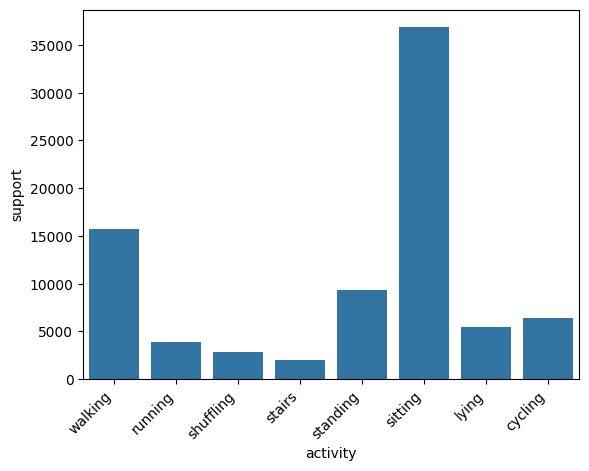

In [ ]:
# Let's plot!
sns.barplot(data=labels_count, x="activity", y="support")
plt.xticks(rotation=45, ha="right")
plt.show()

Very umbalanced!

# NN Model

We are now designing our classifier. I tried different types but the best permorming was the simplest: a 1D CNN. We have 3 convolution layers, each followed by a Max Pooling layer which end in a dense layer with as much neurons as classes (as usual for classifiers!). Kernel size, number of kernel and stride parameters have been chosen sperimentally training the CNN with the original dataset. The results of these training are not reported since it's not the goal (nor the focus) of this project.

In [ ]:
import tensorflow as tf

def cnn_1D_single_input(num_classes=8, print_summary=False):
  acc_input = tf.keras.layers.Input((100, 3), name="acc_input")
  x = tf.keras.layers.Conv1D(filters=32, kernel_size=8, strides=1, activation='relu', name="conv_1")(acc_input)
  x = tf.keras.layers.MaxPooling1D(pool_size=2, strides=2, name="max_pool_1")(x)
  x = tf.keras.layers.Conv1D(filters=64, kernel_size=6, strides=1, activation='relu', name="conv_2")(x)
  x = tf.keras.layers.MaxPooling1D(pool_size=2, strides=2, name="max_pool_2")(x)
  x = tf.keras.layers.Conv1D(filters=96, kernel_size=4, strides=1, activation='relu', name="conv_3")(x)
  x = tf.keras.layers.GlobalMaxPool1D(name='global_max_pooling')(x)
  classification_out = tf.keras.layers.Dense(num_classes, activation='softmax', name="classification_out")(x)

  model = tf.keras.models.Model(inputs=acc_input, outputs=classification_out, name='cnn_1D_acc_single_input')

  if print_summary:
    print(model.summary())

  return model

model = cnn_1D_single_input(print_summary=True)

Model: "cnn_1D_acc_single_input"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ acc_input (InputLayer)               │ (None, 100, 3)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_1 (Conv1D)                      │ (None, 93, 32)              │             800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pool_1 (MaxPooling1D)            │ (None, 46, 32)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_2 (Conv1D)                      │ (None, 41, 64)              │          12,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pool_2 (MaxPooling1D)            │ (None, 20, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_3 (Conv1D)                      │ (None, 17, 96)              │          24,672 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling                   │ (None, 96)                  │               0 │
│ (GlobalMaxPooling1D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ classification_out (Dense)           │ (None, 8)                   │             776 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 38,600 (150.78 KB)

 Trainable params: 38,600 (150.78 KB)

 Non-trainable params: 0 (0.00 B)

None


In [ ]:
# Let's build an utility function that plots in a pretty way confusion matrices

import matplotlib.pyplot as plt
import itertools

def plot_confusion_matrix(cm, classes, normalize=True, cmap=plt.cm.Blues, figsize=(22,8)):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.figure(figsize=figsize)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    #plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=+++90, fontsize=11)
    plt.yticks(tick_marks, classes, fontsize=11)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black"
               )

    plt.ylabel('True label', fontsize=12)
    plt.xlabel('Predicted label', fontsize=12)
    plt.tight_layout()
    plt.tick_params(axis="both", which="both", bottom=False, left=False)
    plt.grid(False)
    plt.box(False) #remove box
    return plt

# SMOTE *inter-subject* data augmentation

Now, we will train our classifier making use of the Synthetic Minority Oversampling Technique, which will generate new data in order to balance all the labels in the train set. The **advantages** of this approach are:
1. *Subject-agnostic learning* : good for learning general activity patterns.
2. *Improved diversity* for rare classes: SMOTE can generate samples using a larger pool of data.
3. *Simplified workflow* : easier to implement and more computationally efficient.

The LOSO validation strategy will be used to test the model.


Iteration 1

Applying SMOTE...

Creating the model...

Training...
Epoch 1/10
1979/1979 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.7790 - loss: 0.5798 - val_accuracy: 0.8589 - val_loss: 0.3640
Epoch 2/10
1979/1979 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - accuracy: 0.8594 - loss: 0.3521 - val_accuracy: 0.8656 - val_loss: 0.3316
Epoch 3/10
1979/1979 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.8743 - loss: 0.3156 - val_accuracy: 0.8770 - val_loss: 0.3089
Epoch 4/10
1979/1979 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8841 - loss: 0.2904 - val_accuracy: 0.8770 - val_loss: 0.3015
Epoch 5/10
1979/1979 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.8913 - loss: 0.2717 - val_accuracy: 0.8970 - val_loss: 0.2607
Epoch 6/10
1979/1979 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.8986 - loss: 0.2562 - val_accuracy: 0.8991 - val_loss: 0.2582
Epoch 7/10
1979/1979 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9049 - loss: 0.2397 - val_accuracy: 0.9003 - val_loss: 0.2527
Epoch 8/10
1979/1

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.10/dist-packages/matplotlib/pyplot.py'>

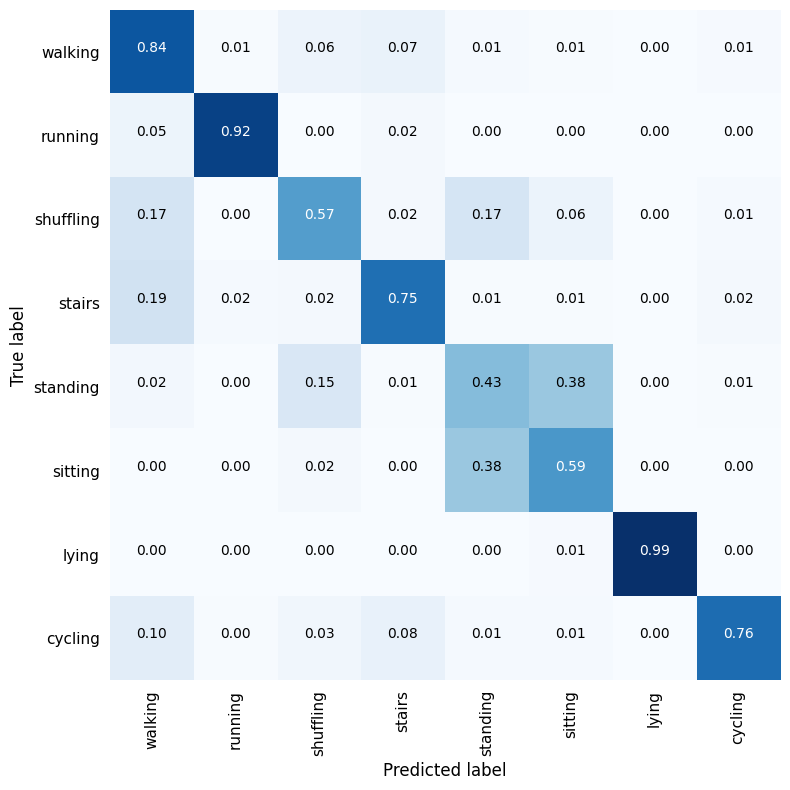

In [ ]:
from sklearn.model_selection import LeaveOneGroupOut, train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import f1_score
from imblearn.over_sampling import SMOTE
from sklearn.metrics import precision_recall_fscore_support

smote = SMOTE(sampling_strategy='auto', k_neighbors=5, random_state=42)
classes_names = list(activities_map.values())
enc = OneHotEncoder()
logo = LeaveOneGroupOut()
split = logo.split(back_samples, labels, subjects)

n_epochs = 10
batch_size = 128

accuracies = [] # we'll collect accuracies, F1 scores, recall and precision for each test
f1_scores = []
precision_scores = []
recall_scores = []

iteration = 0
cm_total = np.zeros((len(classes_names), len(classes_names))) # init the total confusion matrix

for train, test in split:
  iteration += 1
  print(f"\nIteration {iteration}")

  labels_train, labels_test = labels[train], labels[test]
  acc_train, acc_test = back_samples[train], back_samples[test]

  print("\nApplying SMOTE...")

  # Applying SMOTE to train set
  X_resampled, labels_train = smote.fit_resample(acc_train.reshape(acc_train.shape[0], -1), labels_train) # reshape cause SMOTE works with 2D data. (n_windows, n_timestep, n_features) -> (n_windows, n_timestep * n_features)
  acc_train = X_resampled.reshape(-1, acc_train.shape[1], acc_train.shape[2]) # comes back to original shape (n_windows_resampled, n_timestep, n_features)

  # One-Hot encoding for labels
  labels_train = enc.fit_transform(labels_train.reshape(-1, 1)).toarray()
  labels_test = enc.transform(labels_test.reshape(-1, 1)).toarray() # no ".fit" cause fit already done on train (so it already learnt the number of classes)

  # Train/validation split (90-10)
  acc_train, acc_val, labels_train, labels_val = train_test_split(acc_train, labels_train, test_size=0.10, random_state=0)

  print("\nCreating the model...")
  with tf.device(device):
      model = cnn_1D_single_input()
      model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=["accuracy"])

  early_stopping = tf.keras.callbacks.EarlyStopping(patience=3, monitor='val_loss', min_delta=0.01, restore_best_weights=True)

  print("\nTraining...")
  history = model.fit(x=acc_train,
                    y=labels_train,
                    batch_size = batch_size,
                    epochs = n_epochs,
                    validation_data = (acc_val, labels_val),
                    callbacks=[early_stopping])


  print("\nPredicting...")
  y_preds = model.predict(acc_test)

  y_preds = np.argmax(y_preds, axis=1)
  y_targets = np.argmax(labels_test, axis=1)

  # Compute the actual confusion matrix
  cm = confusion_matrix(y_targets, y_preds, labels=np.arange(len(classes_names)))

  # Summing up the actual confusion matrix to the total one
  cm_total += cm

  # Compute metrics for this subject
  precision, recall, f1, _ = precision_recall_fscore_support(y_targets, y_preds, average='macro', zero_division=0)

  # Store metrics
  precision_scores.append(precision)
  recall_scores.append(recall)
  f1_scores.append(f1)

  print("\nClassification Report:")
  print(classification_report(y_targets, y_preds, target_names=classes_names, labels=np.array([i for i in range(len(classes_names))]), digits=4, zero_division=0))

  l, a = model.evaluate(acc_test, labels_test, verbose=False)
  accuracies.append(a) # store accuracy

# Final results
mean_accuracy = np.mean(accuracies)
mean_f1 = np.mean(f1_scores)
mean_precision = np.mean(precision_scores)
mean_recall = np.mean(recall_scores)

print("\nFinal results:")
print(f"Mean accuracy: {mean_accuracy}")
print(f"Mean F1 score: {mean_f1}")
print(f"Mean precision: {mean_precision}")
print(f"Mean recall: {mean_recall}")

plot_confusion_matrix(cm_total, classes=classes_names, normalize=True) # final total confusion matrix


# SMOTE *intra-subject* data augmentation

Here, the SMOTE will generate data for training making use of each subject data separately. This means that, iteratively, it will receive as input the data of one specific subject in the train set.

This approach offers the following **advantages**:
1.   *Subject-specific balancing*: SMOTE would generate synthetic samples by
considering the class distribution for each specific subject. This could enhance the model’s generalization to unseen subjects, as the model would experience better balance within individual subjects.
2.   *Improved intra-subject consistency*: generating new data only within the context of a single subject would maintain the unique characteristics of that subject (e.g., variations in movement or sensor readings). Applying SMOTE globally risks producing synthetic samples that are less representative of individual subject-specific traits.

First of all, we will take a look on how the labels are distributed within the subjects. We DO NOT want to start generating data for a label if a single subject have less then 10 samples for that label. This is an assumption I made to have a reliable data generation (moreover, let's remember that SMOTE cannot even work if the number of samples it exploit to generate synthetic data is less then the number of neighbours!).

In [ ]:
# So, let's see how the labels are distributed between our subjects.
# To do that, we will create a new dataframe, in which we collect for each subject
# the support of the labels

unique_subjects = np.unique(subjects)
unique_labels = np.unique(labels)

# Let's init the dict
data_dict = {activities_map[lab]: [] for lab in unique_labels}
data_dict['subject'] = []

# We loop for each subject
for subject in unique_subjects:
    # We get the labels for this subject only
    subject_labels = labels[subjects == subject]

    # We count the occurances for each label for this subject
    labels_count = {activities_map[lab]: list(subject_labels).count(lab) for lab in unique_labels}

    # Let's add this subject to the dict
    data_dict['subject'].append(subject)

    # Let's add the occurrances for each activity to the dict
    for lab in unique_labels:
        data_dict[activities_map[lab]].append(labels_count[activities_map[lab]])

# From dict to dataframe
support_df = pd.DataFrame(data_dict)

# Let's order the df depending on the subject
support_df = support_df.sort_values(by="subject").reset_index(drop=True)

support_df


,walking,running,shuffling,stairs,standing,sitting,lying,cycling,subject
0,179,0,48,18,419,1681,85,263,0
1,287,0,352,17,866,3892,0,122,1
2,75,0,2,14,75,0,0,1885,2
3,2357,0,364,128,1205,616,0,0,3
4,166,29,74,98,300,4143,248,0,4
5,442,47,472,90,706,2966,89,38,5
6,357,31,215,131,735,3144,115,73,6
7,725,40,133,192,895,2592,833,120,7
8,525,37,203,37,702,2523,520,145,8
9,478,67,107,197,405,2892,576,120,9


In [ ]:
# Let's now get only the subjects (and labels) with less then 10 samples
# We set the subject as index and substitute the supports bigger then 10 (or equal to zero) with NaN,
# wich will represent the not-under represented classes
underrepresented_classes = support_df.set_index('subject').applymap(lambda x: x if 0 < x < 10 else np.nan)

# We select the classes not having NaN values (so the under-represented)
underrepresented_classes = underrepresented_classes[underrepresented_classes.any(axis=1)]

underrepresented_classes


<ipython-input-15-fec3d9ae2042>:4: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  underrepresented_classes = support_df.set_index('subject').applymap(lambda x: x if 0 < x < 10 else np.nan)


,walking,running,shuffling,stairs,standing,sitting,lying,cycling
subject,,,,,,,,
2,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN
19,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN


In [ ]:
# So now we know which subjects have a class with less then 10 samples (and we also know which class!)
# Let's get rid of them!

classes_to_remove = {
    2: "shuffling",
    19: "stairs"
}

# Indeces of the samples to remove
indices_to_remove = []

# Loop between subject and class to remove
for subject, activity in classes_to_remove.items():
    # Find the indeces of the elements to remove
    activity_label = [key for key, value in activities_map.items() if value == activity][0]
    indices = np.where((subjects == subject) & (labels == activity_label))[0]
    indices_to_remove.extend(indices)

# Let's get rid of those indeces
back_samples_filtered = np.delete(back_samples, indices_to_remove, axis=0)
thigh_samples_filtered = np.delete(thigh_samples, indices_to_remove, axis=0)
labels_filtered = np.delete(labels, indices_to_remove, axis=0)
subjects_filtered = np.delete(subjects, indices_to_remove, axis=0)
tss_filtered = np.delete(tss, indices_to_remove, axis=0)

# Let's check, we should've lost 3 windows
print(f"Back data: {back_samples_filtered.shape}")
print(f"Thigh data: {thigh_samples_filtered.shape}")
print(f"Labels data: {labels_filtered.shape}")
print(f"Subjects data: {subjects_filtered.shape}")


Back data: (82605, 100, 3)
Thigh data: (82605, 100, 3)
Labels data: (82605,)
Subjects data: (82605,)


We are now going to create the function to apply SMOTE to each of our subjects in the train set separately.

In [ ]:
from imblearn.over_sampling import SMOTE
from collections import Counter

def smote_by_subject(back_samples, labels, subjects):
    smote = SMOTE(sampling_strategy='auto', k_neighbors=5, random_state=42)
    new_back_samples = []
    new_labels = []

    for subject in np.unique(subjects):
        # Retrieve data for the current subject
        mask = subjects == subject
        back_subj = back_samples[mask]
        labels_subj = labels[mask]

        # Apply SMOTE to the train data of the current subject
        X_resampled, y_resampled = smote.fit_resample(back_subj.reshape(back_subj.shape[0], -1), labels_subj)
        back_resampled = X_resampled.reshape(-1, back_subj.shape[1], back_subj.shape[2])

        # Store the new synth data
        new_back_samples.append(back_resampled)
        new_labels.append(y_resampled)

    # Combine data from all the subjects
    new_back_samples = np.vstack(new_back_samples)
    new_labels = np.hstack(new_labels)

    return new_back_samples, new_labels



Iteration 1

Applying SMOTE...

Creating the model...

Training...
Epoch 1/10
2443/2443 ━━━━━━━━━━━━━━━━━━━━ 15s 5ms/step - accuracy: 0.7517 - loss: 0.6473 - val_accuracy: 0.8393 - val_loss: 0.4086
Epoch 2/10
2443/2443 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - accuracy: 0.8475 - loss: 0.3892 - val_accuracy: 0.8523 - val_loss: 0.3642
Epoch 3/10
2443/2443 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.8675 - loss: 0.3383 - val_accuracy: 0.8761 - val_loss: 0.3166
Epoch 4/10
2443/2443 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.8809 - loss: 0.3033 - val_accuracy: 0.8819 - val_loss: 0.3038
Epoch 5/10
2443/2443 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.8910 - loss: 0.2781 - val_accuracy: 0.9004 - val_loss: 0.2665
Epoch 6/10
2443/2443 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.9002 - loss: 0.2559 - val_accuracy: 0.8911 - val_loss: 0.2760
Epoch 7/10
2443/2443 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.9061 - loss: 0.2409 - val_accuracy: 0.8956 - val_loss: 0.2755
Epoch 8/10
2443/2

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.10/dist-packages/matplotlib/pyplot.py'>

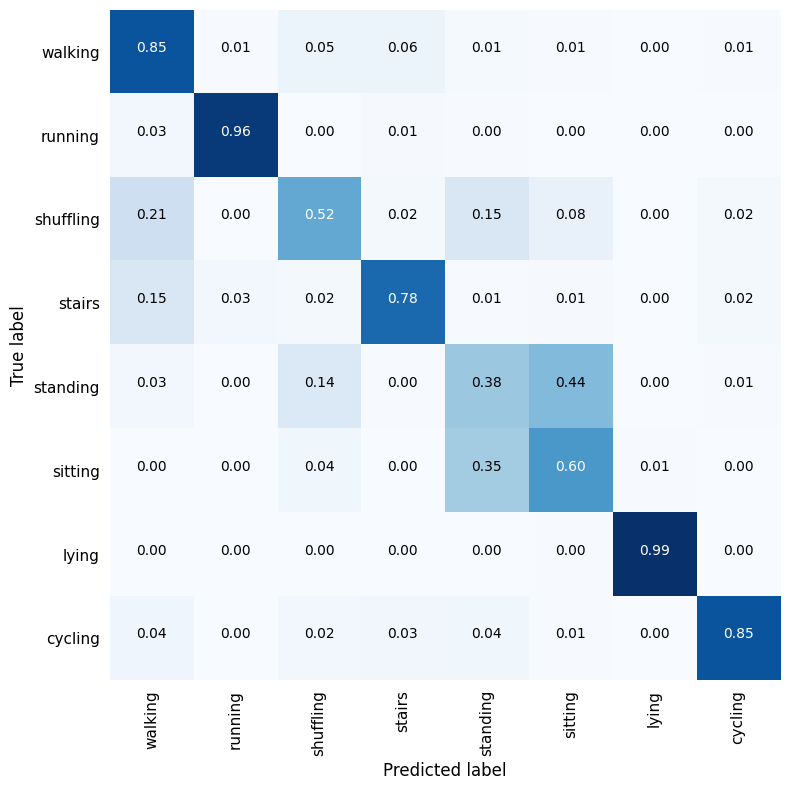

In [ ]:
from sklearn.model_selection import LeaveOneGroupOut, train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import f1_score

classes_names = list(activities_map.values())
enc = OneHotEncoder()
logo = LeaveOneGroupOut()
split = logo.split(back_samples_filtered, labels_filtered, subjects_filtered)

n_epochs = 10
batch_size = 128

accuracies = []
f1_scores = []
precision_scores = []
recall_scores = []

iteration = 0
cm_total = np.zeros((len(classes_names), len(classes_names))) # init the total confusion matrix

for train, test in split:
  iteration += 1
  print(f"\nIteration {iteration}")

  labels_train, labels_test = labels_filtered[train], labels_filtered[test]
  acc_train, acc_test = back_samples_filtered[train], back_samples_filtered[test]
  subjects_train, subjects_test = subjects_filtered[train], subjects_filtered[test]

  # Apply SMOTE to each subject separately
  print("\nApplying SMOTE...")
  acc_train, labels_train = smote_by_subject(acc_train, labels_train, subjects_train)

  # One-hot encoding for labels
  labels_train = enc.fit_transform(labels_train.reshape(-1, 1)).toarray()
  labels_test = enc.transform(labels_test.reshape(-1, 1)).toarray()

  # Train/validation split (90/10)
  acc_train, acc_val, labels_train, labels_val = train_test_split(acc_train, labels_train, test_size=0.10, random_state=0)

  print("\nCreating the model...")
  with tf.device(device):
      model = cnn_1D_single_input()
      model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=["accuracy"])

  early_stopping = tf.keras.callbacks.EarlyStopping(patience=3, monitor='val_loss', min_delta=0.01, restore_best_weights=True)

  print("\nTraining...")
  history = model.fit(x=acc_train,
                    y=labels_train,
                    batch_size = batch_size,
                    epochs = n_epochs,
                    validation_data = (acc_val, labels_val),
                    callbacks=[early_stopping])


  print("\nPredicting...")
  y_preds = model.predict(acc_test)

  y_preds = np.argmax(y_preds, axis=1)
  y_targets = np.argmax(labels_test, axis=1)

  # Compute metrics for this subject
  precision, recall, f1, _ = precision_recall_fscore_support(y_targets, y_preds, average='macro', zero_division=0)

  # Store the metrics
  precision_scores.append(precision)
  recall_scores.append(recall)
  f1_scores.append(f1)

  # Compute the actual confusion matrix
  cm = confusion_matrix(y_targets, y_preds, labels=np.arange(len(classes_names)))

  # Summing up the actual confusion matrix to the total one
  cm_total += cm

  print("\nClassification Report:")
  print(classification_report(y_targets, y_preds, target_names=classes_names, labels=np.array([i for i in range(len(classes_names))]), digits=4, zero_division=0))

  l, a = model.evaluate(acc_test, labels_test, verbose=False)
  accuracies.append(a)

# Final results
mean_accuracy = np.mean(accuracies)
mean_f1 = np.mean(f1_scores)
mean_precision = np.mean(precision_scores)
mean_recall = np.mean(recall_scores)

print(f"\nMean accuracy: {mean_accuracy}")
print(f"Mean F1 score: {mean_f1}")
print(f"Mean precision: {mean_precision}")
print(f"Mean recall: {mean_recall}")

plot_confusion_matrix(cm_total, classes=classes_names, normalize=True) # final total confusion matrix


# DIFFUSION MODEL

Now comes the fun part! We have to build our diffusion model! This means that we have to design:

1. **The Forward Process**, where we apply noise diffusion to our original data.
2. **The U-Net Architecture**, a neural network which will have the task of, given a noisy sample, predict the noise added to the original sample.
3. **The Backward Process**, through which we will be able to *transform* pure noise into synthetic data.

## Forward Process

In the Forward Process, one basically adds gaussian noise (ϵ) to the data iteratively in $T$ steps. The noise added at timestep $t$ depends only on the previous step $t-1$, so we have a Markov Chain.

Now, given that a sum of Gaussians is still a Gaussian, we are able to directly compute the noisy version of the data for a specific timestep, without the need to iterate the process step by step. Given the original data, we can sample the noisy version of the data at the timestep $t$, making use of 3 sequences of values: ${\beta}_t$, ${\alpha}_t$, $\bar{\alpha}_t$, with the following properties:

1. ${\beta}_t$ is a sequence of equispaced values, ranging from $0$ and $T$. They describe how much noise is present in the noisy sample.

2. ${\alpha}_t = 1-{\beta}_t$, representing how much information from the original data is present in the noisy sample.

3. $\bar{\alpha}_t = \prod_{s=1}^{t} {\alpha}_s$

Given these 3 sequence of values, one can extract the noisy sample $x_t$ of the original data $x_{0}$ at the timestep $t$ with the following:

$q(\mathbf{x}_t|\mathbf{x}_0) = \mathcal{N}(\mathbf{x}_t; \sqrt{\bar{\alpha}_t} \mathbf{x}_0, (1 - \bar{\alpha}_t) \mathbf{I})$


In [ ]:
def forward_diffusion(x_0, t, T=1000, beta_start=1e-4, beta_end=0.01):
    """
    x_0: Original window (100, 3)
    t: Current timestep
    T: Total number of timesteps
    beta_start: Initial value for beta
    beta_end: Final value for beta

    """
    # Let's define the sequence of alphas and betas, given T
    betas = np.linspace(beta_start, beta_end, T)
    alphas = np.cumprod(1 - betas)

    # Let's compute the current alpha, given t
    alpha_t = alphas[t]

    # Let's add gaussian noise to the original window
    epsilon = np.random.normal(0, 1, x_0.shape)
    x_t = np.sqrt(alpha_t) * x_0 + np.sqrt(1 - alpha_t) * epsilon

    return x_t, epsilon # noisy window, gaussian noise


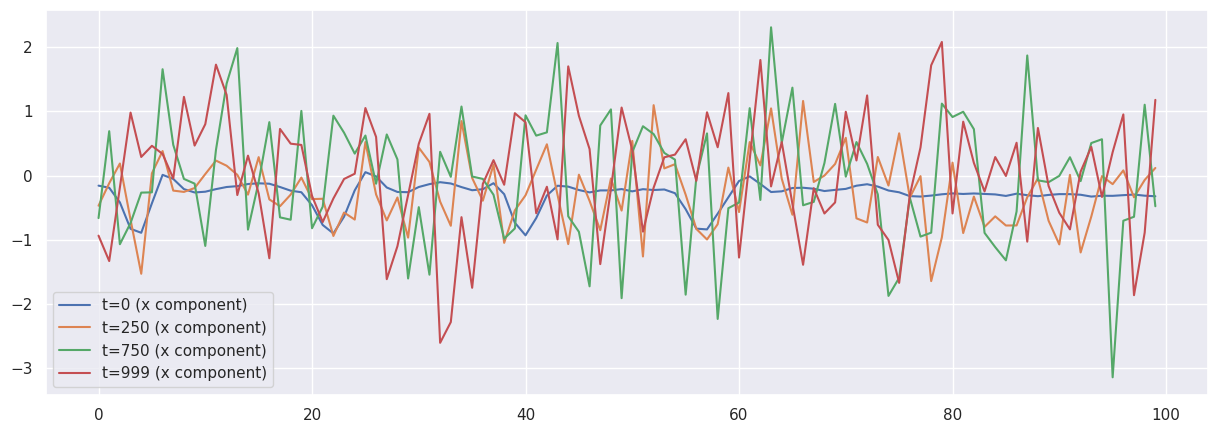

In [ ]:
# Let's have a look at this process, watching how the x-component of the original window got degradeted!
sample_back = back_samples[158]

for t in [0, 250, 750, 999]:
    noisy_sample, _ = forward_diffusion(sample_back, t)
    plt.plot(noisy_sample[:, 0], label=f't={t} (x component)')

plt.legend()
plt.show()

Now, we apply the diffusion to all of our original windows!

For each original window, we apply diffusion with a **random timestep** $t$. In particular, for each original window, we will generate **2 different noisy versions** of it (this is due to the computational capabilities, otherwise we'd kill the RAM)

In [ ]:
T = 1000
i = 0

noisy_samples = []  # store the noisy samples
noise_samples = []  # store the added gaussian noise
noisy_labels = [] # keep track of the label
noisy_subjects = [] # keep track of the subject
timesteps = []  # store the timestep t

# Loop over all the original windows
for i, x_0 in enumerate(back_samples):
    for _ in range(2): # for each original window, create 2 noisy versions
        t = np.random.randint(0, T)  # sample a random t
        x_t, epsilon = forward_diffusion(x_0, t, T=T)  # Forward diffusion!

        # Store everything!
        noisy_samples.append(x_t)
        noise_samples.append(epsilon)
        timesteps.append(t)
        noisy_labels.append(labels[i])
        noisy_subjects.append(subjects[i])

# Array numpy conversion, because all this will be fed to the U-Net
X_train = np.array(noisy_samples)
y_train = np.array(noise_samples)
timesteps = np.array(timesteps)
noisy_labels = np.array(noisy_labels)
noisy_subjects = np.array(noisy_subjects)

# Check the dimensions, we should get twice the number of original windows, so 82608 * 2 = 165216
print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of timesteps: {timesteps.shape}")
print(f"Shape of noisy_labels: {noisy_labels.shape}")
print(f"Shape of noisy_subjects: {noisy_subjects.shape}")


Shape of X_train: (165216, 100, 3)
Shape of y_train: (165216, 100, 3)
Shape of timesteps: (165216,)
Shape of noisy_labels: (165216,)
Shape of noisy_subjects: (165216,)


## Conditional U-NET

The U-Net is a neural network with a U-shaped architecture that consists of an encoder network to downsample the input data, and a decoder network to
upsample the encoded data back to the original size. It's goal is to detect the gaussian noise $\epsilon$ added to the original data $x_0$, given the noisy data $x_t$. So, basically, the noisy windows we've just generated with the forward diffusion process will be used to feed the U-Net!

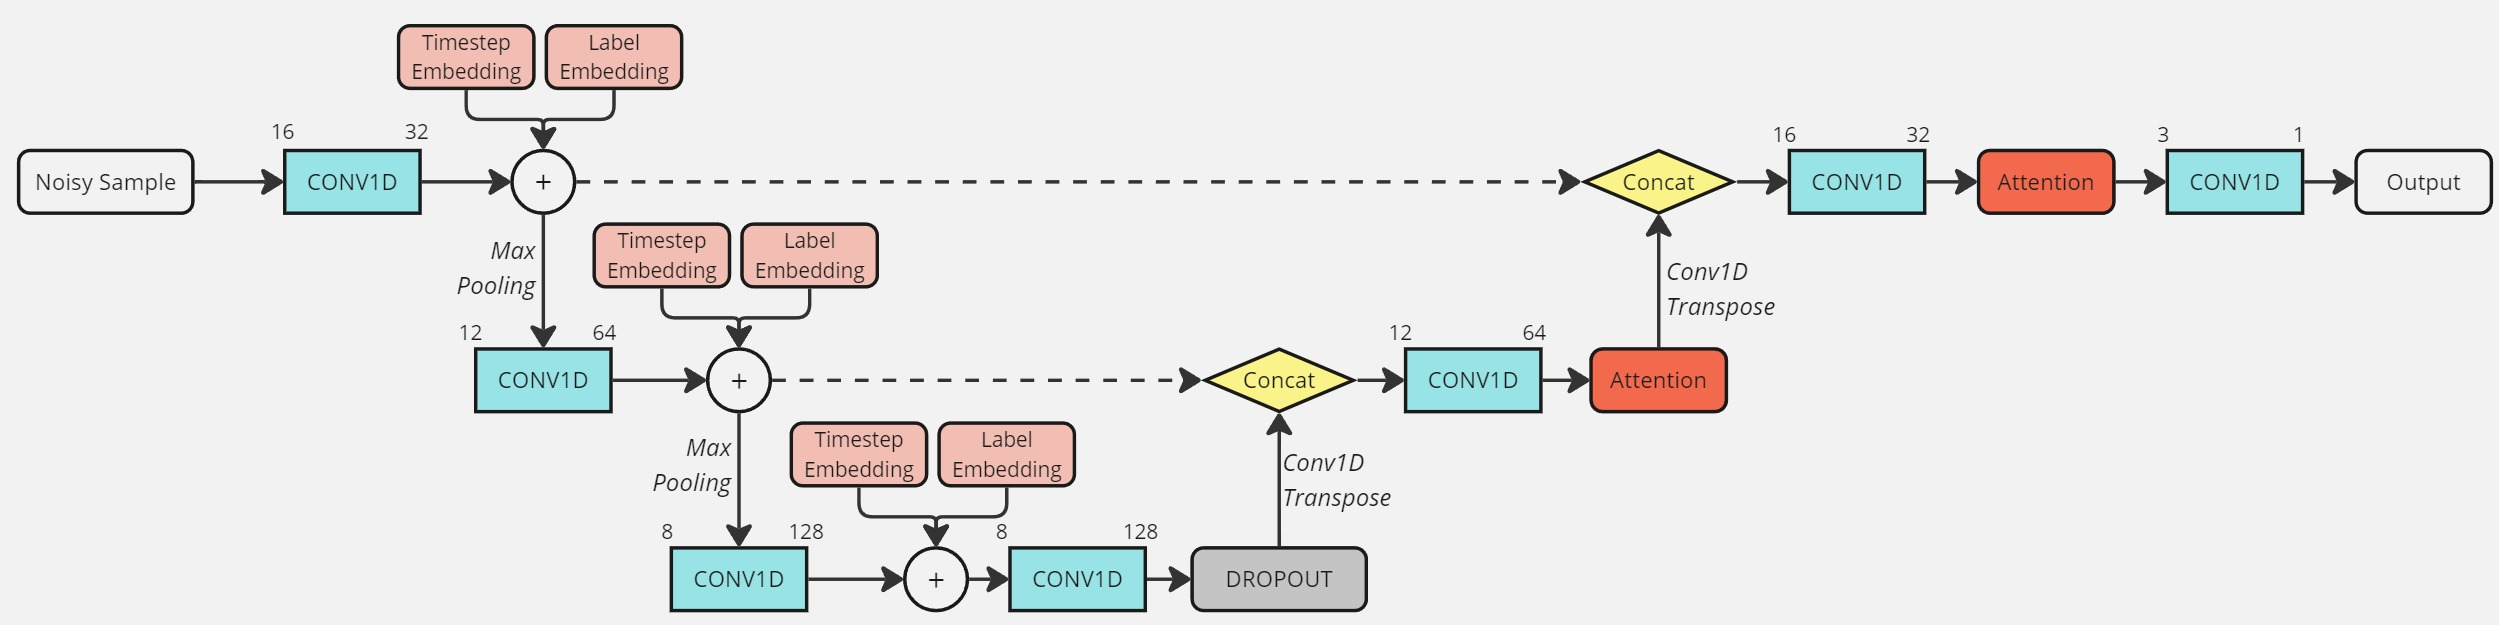

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
'''
We are now going to create the main function for our U-Net model. These will include:
- Embedding for the timestep
- 1D convolutional block
- Attention block
- Upsampling block (with skip connection)

'''

# Custom layer for timestep embedding
class TimestepEmbedding(layers.Layer):
    def __init__(self, dim, **kwargs):
        super(TimestepEmbedding, self).__init__(**kwargs)
        self.dim = dim

    def build(self, input_shape):
        half_dim = self.dim // 2
        self.emb_scale = tf.exp(tf.range(half_dim, dtype=tf.float32) * -tf.math.log(10000.0) / (half_dim - 1))

    def call(self, timesteps):
        timesteps = tf.cast(timesteps, dtype=tf.float32)
        emb = timesteps[:, None] * self.emb_scale[None, :]
        emb = tf.concat([tf.sin(emb), tf.cos(emb)], axis=-1)
        return emb

# Simple 1D convolutional block
def conv_block(input_tensor, kernel_size, num_filters):

    # Apply Conv1D layer with HeNormal initializer
    x = layers.Conv1D(num_filters,
                      kernel_size,
                      strides=1,
                      padding='same',
                      kernel_initializer=tf.keras.initializers.HeNormal()
                      )(input_tensor)

    # Apply ReLU activation
    x = layers.ReLU()(x)

    return x

# Attention Block
def attention_block(x, g, inter_channels):

    # Apply Conv1D to input x and gating signal g, reducing their channel dimension
    theta_x = layers.Conv1D(inter_channels, 1)(x)
    phi_g = layers.Conv1D(inter_channels, 1)(g)

    # Add the two transformed inputs and apply ReLU
    f = layers.add([theta_x, phi_g])
    f = layers.ReLU()(f)

    # Apply another Conv1D with sigmoid activation for gating
    psi_f = layers.Conv1D(1, 1, activation='sigmoid')(f)

    # Multiply input x by the gating signal
    return layers.multiply([x, psi_f])

# Upsampling block with skip connection
def up_conv_block(input_tensor, skip_tensor, kernel_size, num_filters):

    # Apply Conv1DTranspose layer for upsampling
    x = layers.Conv1DTranspose(num_filters, kernel_size, strides=2, padding='same')(input_tensor)

    # Concatenate the upsampled input with the skip connection tensor
    x = layers.concatenate([x, skip_tensor])

    # Apply a Conv1D block to the concatenated tensor
    x = conv_block(x, kernel_size, num_filters)

    return x

# Function to resize embedding to match target length and channel size
def resize_embedding(t_emb, target_length, num_channels):

    # Resize the timestep embedding using Dense layer to match target temporal length and channels
    t_emb = layers.Dense(target_length * num_channels, activation='relu')(t_emb)

    # Reshape the embedding to have the target length and number of channels
    t_emb = layers.Reshape((target_length, num_channels))(t_emb)

    return t_emb


In [ ]:
'''
Our U-Net will have the following input and output:

INPUTS:
    1) The noisy window (100, 3)
    2) The timestep
    3) The label

OUTPUT: The gaussian noise (100, 3)

Its architecture is:

1) Embeddings for the timestep and the label

2) Downsampling path:
    - Conv Block 1 (c1): A convolutional block is applied with a kernel size of 16, producing 32 features. At this point, the timestep and label embeddings are resized (resize_embedding) and added to the result of the convolutional block.

    - Max Pooling 1 (p1): Reduces the dimension using pooling with a factor of 2.

    - Conv Block 2 (c2): Similar to the first block, but with a kernel size of 12 and 64 features. Again, timestep and label embeddings are added.

    - Max Pooling 2 (p2): Further reduces the dimension with pooling.

    - Conv Block 3 (c3): The third convolutional block with a kernel size of 8 and 128 features. The timestep and label embeddings are added once more.

3) Bottleneck:
    - In this layer, the network applies another convolutional block with 128 features and a Dropout with a rate of 0.1 to prevent overfitting.

4) Upsampling path:
    - Up Conv Block 1 (u1): A Conv1DTranspose layer is applied for upsampling, followed by concatenation with features from the second downsampling layer (c2). The subsequent convolutional block is then refined by an attention block, which modulates the features based on the context from c2.

    - Up Conv Block 2 (u2): Similar to the first upsampling block, but with a larger kernel (16) and 32 features. The attention block modulates the output using context from c1.

5) Output layer:
    - Finally, a Conv1D layer with a kernel size of 1 and 3 features produces the network's output with a linear activation. This represents the final prediction for each timestep in the sequence.

'''

def build_unet(input_shape=(100, 3)):
    inputs = layers.Input(input_shape)
    t_input = layers.Input(shape=(1,), dtype=tf.int32)
    label_input = layers.Input(shape=(1,), dtype=tf.int32)

    # Timestep Embedding
    t_emb = TimestepEmbedding(input_shape[0])(t_input)

    # Label Embedding
    label_emb = layers.Embedding(input_dim=8, output_dim=16)(label_input)

    # Downsampling path
    c1 = conv_block(inputs, 16, 32)
    t_emb_resized = resize_embedding(t_emb, c1.shape[1], 32)
    label_emb_resized = resize_embedding(label_emb, c1.shape[1], 32)
    c1 = layers.add([c1, t_emb_resized, label_emb_resized])
    p1 = layers.MaxPooling1D(2)(c1)

    c2 = conv_block(p1, 12, 64)
    t_emb_resized = resize_embedding(t_emb, c2.shape[1], 64)
    label_emb_resized = resize_embedding(label_emb, c2.shape[1], 64)
    c2 = layers.add([c2, t_emb_resized, label_emb_resized])
    p2 = layers.MaxPooling1D(2)(c2)

    c3 = conv_block(p2, 8, 128)
    t_emb_resized = resize_embedding(t_emb, c3.shape[1], 128)
    label_emb_resized = resize_embedding(label_emb, c3.shape[1], 128)
    c3 = layers.add([c3, t_emb_resized, label_emb_resized])

    # Bottleneck
    b = conv_block(c3, 8, 128)
    b = layers.Dropout(0.1)(b)

    # Upsampling path
    u1 = up_conv_block(b, c2, 12, 64)
    u1 = attention_block(u1, c2, 64)

    u2 = up_conv_block(u1, c1, 16, 32)
    u2 = attention_block(u2, c1, 32)

    # Output
    outputs = layers.Conv1D(3, 1, activation='linear')(u2)

    model = tf.keras.Model(inputs=[inputs, t_input, label_input], outputs=outputs)
    return model


In [ ]:
unet_model = build_unet()
unet_model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 1)              │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_2             │ (None, 1)              │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer (InputLayer)  │ (None, 100, 3)         │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ timestep_embedding        │ (None, 1, 100)         │              0 │ input_layer_1[0][0]    │
│ (TimestepEmbedding)       │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding (Embedding)     │ (None, 1, 16)          │            128 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d (Conv1D)           │ (None, 100, 32)        │          1,568 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 1, 3200)        │        323,200 │ timestep_embedding[0]… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 1, 3200)        │         54,400 │ embedding[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu (ReLU)              │ (None, 100, 32)        │              0 │ conv1d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape (Reshape)         │ (None, 100, 32)        │              0 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape_1 (Reshape)       │ (None, 100, 32)        │              0 │ dense_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 100, 32)        │              0 │ re_lu[0][0],           │
│                           │                        │                │ reshape[0][0],         │
│                           │                        │                │ reshape_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling1d             │ (None, 50, 32)         │              0 │ add[0][0]              │
│ (MaxPooling1D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_1 (Conv1D)         │ (None, 50, 64)         │         24,640 │ max_pooling1d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 1, 3200)        │        323,200 │ timestep_embedding[0]… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_3 (Dense)           │ (None, 1, 3200)        │         54,400 │ embedding[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_1 (ReLU)       

 Total params: 1,628,965 (6.21 MB)

 Trainable params: 1,628,965 (6.21 MB)

 Non-trainable params: 0 (0.00 B)

It's time now to train our U-Net!

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split

# Let's save the best weights!
checkpoint = ModelCheckpoint(filepath='/content/drive/MyDrive/machine learning/Ambient/harth/best_unet_model_new.weights.h5',
                             monitor='val_loss',
                             save_best_only=True,
                             save_weights_only=True,
                             mode='min',
                             verbose=0)

# Learning rate schedule
lr_schedule = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                   factor=0.5,
                                                   patience=3,
                                                   min_lr=1e-8
                                                   )

#optimizer = tf.keras.optimizers.SGD(learning_rate=0.05)
optimizer = tf.keras.optimizers.AdamW(learning_rate=1e-4, weight_decay=1e-5)


# Train/test split (70/30)

X_train, X_test, y_train, y_test, timesteps_train, timesteps_test, noisy_labels_train, noisy_labels_test, noisy_subjects_train, noisy_subjects_test = train_test_split(
    X_train, y_train, timesteps, noisy_labels, noisy_subjects, test_size=0.3, random_state=42)

# Training
with tf.device(device):
    unet_model = build_unet()
    unet_model.compile(optimizer=optimizer, loss='mse')
    history = unet_model.fit([X_train, timesteps_train, noisy_labels_train],
                             y_train,
                             batch_size=512,
                             epochs=30,
                             validation_data=([X_test, timesteps_test, noisy_labels_test], y_test),
                             callbacks=[lr_schedule, checkpoint],
                             shuffle=True)



Epoch 1/30
226/226 ━━━━━━━━━━━━━━━━━━━━ 44s 106ms/step - loss: 1.0081 - val_loss: 0.3612 - learning_rate: 1.0000e-04
Epoch 2/30
226/226 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - loss: 0.3225 - val_loss: 0.2566 - learning_rate: 1.0000e-04
Epoch 3/30
226/226 ━━━━━━━━━━━━━━━━━━━━ 9s 40ms/step - loss: 0.2458 - val_loss: 0.2186 - learning_rate: 1.0000e-04
Epoch 4/30
226/226 ━━━━━━━━━━━━━━━━━━━━ 11s 41ms/step - loss: 0.2115 - val_loss: 0.1963 - learning_rate: 1.0000e-04
Epoch 5/30
226/226 ━━━━━━━━━━━━━━━━━━━━ 10s 40ms/step - loss: 0.1911 - val_loss: 0.1792 - learning_rate: 1.0000e-04
Epoch 6/30
226/226 ━━━━━━━━━━━━━━━━━━━━ 11s 41ms/step - loss: 0.1769 - val_loss: 0.1665 - learning_rate: 1.0000e-04
Epoch 7/30
226/226 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - loss: 0.1629 - val_loss: 0.1552 - learning_rate: 1.0000e-04
Epoch 8/30
226/226 ━━━━━━━━━━━━━━━━━━━━ 9s 40ms/step - loss: 0.1533 - val_loss: 0.1458 - learning_rate: 1.0000e-04
Epoch 9/30
226/226 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - loss: 0.1437 - va

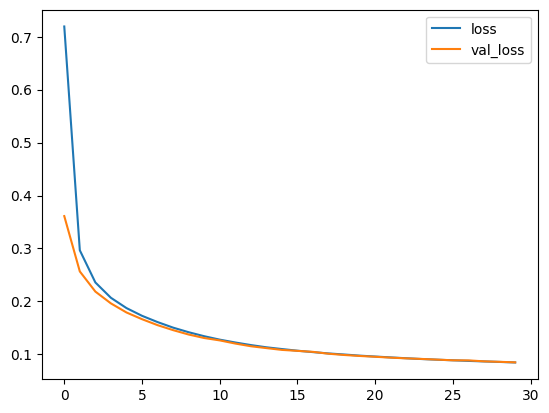

In [ ]:
# Let's see how it went

plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.show()


## Backward Process - Data Generation

Finally, the last (and, personally, the most interesting) step! We have to generate new data starting from pure noise. Basically, we will iteratively prune noise away from the pure noise till a brand new window of 3D accelerometer data is reached. To do it, we implement 3 functions:
1. A function to generate new windows exploiting the U-Net we previously trained.
2. A function that counts up how many windows for each label we actually need to augment the minority labels.
3. A function that cleans the resulting synthetic windows, before feeding them to the classifier during the training.

Let's start from the latter.

In [ ]:
#... but first, load the U-Net weights!
with tf.device(device):
    unet_model = build_unet()
    unet_model.load_weights('/content/drive/MyDrive/machine learning/Ambient/harth/best_unet_model_new.weights.h5')  # Carica i pesi del miglior modello

In [ ]:
import pandas as pd

# Function to clean the synth windows

def clean_synthetic_data(synthetic_data):

    # Temporary dataframe of the synth data
    df_synthetic = pd.DataFrame(synthetic_data.reshape(-1, synthetic_data.shape[-1]), columns=["acc_x", "acc_y", "acc_z"])

    # Apply the filter!
    df_synthetic["acc_x"] = df_synthetic["acc_x"].rolling(window=3, center=True, win_type='gaussian').mean(std=1).bfill().ffill()
    df_synthetic["acc_y"] = df_synthetic["acc_y"].rolling(window=3, center=True, win_type='gaussian').mean(std=1).bfill().ffill()
    df_synthetic["acc_z"] = df_synthetic["acc_z"].rolling(window=3, center=True, win_type='gaussian').mean(std=1).bfill().ffill()

    # Convert back to numpy and reshape
    cleaned_synthetic_data = df_synthetic.values.reshape(synthetic_data.shape)

    return cleaned_synthetic_data # cleaned synth data!


In [ ]:
# Function to generate the synth windows exploiting the U-Net.
# Basically, it works like this:
# 1) Generate pure noise
# 2) Given T, get the beta and alpha sequences
# 3) Starting from T = 1000 to T = 0, with step of 100, predict the noise with the trained U-Net
# 4) Predicted the gaussian noise, retrieve the denoised data using the reverse equation of x_t

def generate_synthetic_data(unet_model, timesteps, num_synth_windows, input_shape, label, beta_start=1e-4, beta_end=0.01):
    """
    unet_model: The U-Net model used for denoising.
    timesteps: The total number of timesteps for the denoising process.
    num_synth_windows: The number of synthetic windows to generate.
    input_shape: The shape of the input data (es. (100, 3)).
    label: The label for which to generate synthetic data.
    beta_start: Initial value for beta
    beta_end: Final value for beta

    Returns:
        Synthetic data (num_synth_windows x window_length x num_channels).
    """
    # Initial pure noise
    noise = np.random.normal(size=(num_synth_windows, input_shape[0], input_shape[1]))

    # Betas and alphas
    betas = np.linspace(beta_start, beta_end, timesteps)
    alphas = np.cumprod(1 - betas)

    # Retrieve the number of timesteps and labels, in order to create both new windows and labels
    timestep_values = np.full((num_synth_windows, 1), timesteps)
    label_values = np.full((num_synth_windows, 1), label)

    # Iterative denoising step
    for t in reversed(range(0, timesteps, 100)): # here the step has been chosen due to computational capabilities!!
        # Update the timestep for the current iteration
        timestep_values.fill(t)

        # U-Net predicts the noise
        predicted_noise = unet_model.predict([noise, timestep_values, label_values], verbose=0)

        # Compute current alpha_t
        alpha_t = alphas[t]

        # Remove the predicted noise with the reversed equation
        x_0_pred = (noise - np.sqrt(1 - alpha_t) * predicted_noise) / np.sqrt(alpha_t)

        # If not the last step, update the noise for the next denoising step
        if t > 0:
            alpha_t_prev = alphas[t - 100] if t - 100 >= 0 else alphas[0]
            noise = np.sqrt(alpha_t_prev) * x_0_pred + np.sqrt(1 - alpha_t_prev) * predicted_noise
        else:
            noise = x_0_pred  # If it's the last step, return the denoised data

    synthetic_data = clean_synthetic_data(noise) # clean the denoised data

    return synthetic_data # new fresh synthetic data!


In [ ]:
# Function to generate windows for the minority labels.
# Basically, it tells the previous function how many windows to generate and what are their labels.

def generate_synthetic_data_for_class(unet_model, timesteps, input_shape, labels_train):
    """
    labels_train: The train set labels

    Returns Balanced synthetic data.
    """
    # Find the unique labels and the number of examples for each class in the train set
    class_labels, class_counts = np.unique(labels_train, return_counts=True)
    max_count = class_counts.max()  # Number of examples for the most represented class

    synthetic_data = []
    synthetic_labels = []

    # Loop for each under-represented class
    for class_label, count in zip(class_labels, class_counts):
        if count < max_count:
            num_to_generate = (max_count - count)//2  # How many windows to generate for this class (this has been chosen due to computational capabilities)

            # Generate synthetic data for this class
            generated_data = generate_synthetic_data(
                unet_model,
                timesteps,
                num_synth_windows=num_to_generate,
                input_shape=input_shape,
                label=class_label
            )

            # Merge the synth data
            synthetic_data.append(generated_data)
            synthetic_labels.extend([class_label] * num_to_generate)

    # Concatenate the synth data and return them
    return np.concatenate(synthetic_data, axis=0), np.array(synthetic_labels)


## Train with Diffusion Model data augmentation


Iteration 1

Generating synthetic data to train the model...

Creating the model...

Training...
Epoch 1/10
1271/1271 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.6211 - loss: 0.9770 - val_accuracy: 0.7014 - val_loss: 0.7423
Epoch 2/10
1271/1271 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.7118 - loss: 0.7161 - val_accuracy: 0.7117 - val_loss: 0.7162
Epoch 3/10
1271/1271 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.7224 - loss: 0.6809 - val_accuracy: 0.7175 - val_loss: 0.6794
Epoch 4/10
1271/1271 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.7268 - loss: 0.6677 - val_accuracy: 0.7265 - val_loss: 0.6707
Epoch 5/10
1271/1271 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.7338 - loss: 0.6512 - val_accuracy: 0.7326 - val_loss: 0.6556
Epoch 6/10
1271/1271 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.7399 - loss: 0.6394 - val_accuracy: 0.7287 - val_loss: 0.6556
Epoch 7/10
1271/1271 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.7494 - loss: 0.6186 - val_accuracy: 0.7277 - val_loss

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.10/dist-packages/matplotlib/pyplot.py'>

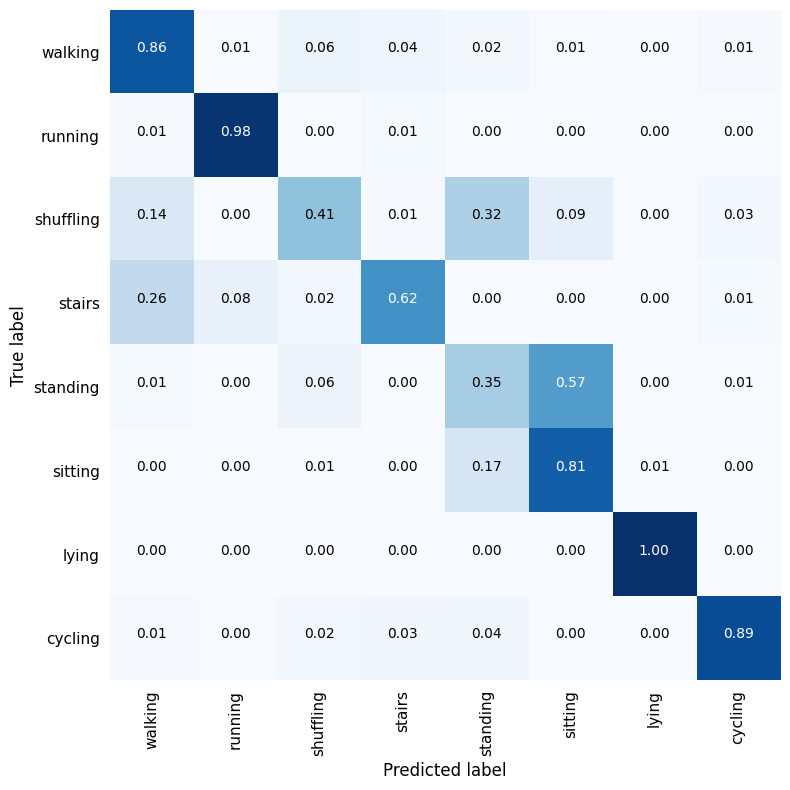

In [ ]:
from sklearn.model_selection import LeaveOneGroupOut, train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix

classes_names = list(activities_map.values())
enc = OneHotEncoder()
logo = LeaveOneGroupOut()
split = logo.split(back_samples, labels, subjects)

n_epochs = 10
batch_size = 128

# Initialize lists to store the metrics
accuracies = []
f1_scores = []
precision_scores = []
recall_scores = []

iteration = 0
cm_total = np.zeros((len(classes_names), len(classes_names))) # init the total confusion matrix

# Diffusion model parameters
n_timesteps = 1000
input_shape = (100, 3)

for train, test in split:
    iteration += 1
    print(f"\nIteration {iteration}")

    labels_train, labels_test = labels[train], labels[test]
    acc_train, acc_test = back_samples[train], back_samples[test]

    print("\nGenerating synthetic data to train the model...")

    # Generating synthetic data to balance the under-represented classes in the train set
    synthetic_data, synthetic_label = generate_synthetic_data_for_class(
        unet_model=unet_model,
        timesteps=n_timesteps,
        input_shape=input_shape,
        labels_train=labels_train,
    )

    # Concatenate the synthetic data to the train set
    acc_train = np.concatenate([acc_train, synthetic_data], axis=0)
    labels_train = np.concatenate([labels_train, synthetic_label], axis=0)

    # One-hot encoding for the labels
    labels_train = enc.fit_transform(labels_train.reshape(-1, 1)).toarray()
    labels_test = enc.transform(labels_test.reshape(-1, 1)).toarray()

    # Train/validation split (90/10)
    acc_train, acc_val, labels_train, labels_val = train_test_split(acc_train, labels_train, test_size=0.10, random_state=0)

    print("\nCreating the model...")
    with tf.device(device):
        model = cnn_1D_single_input()
        model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=["accuracy"])

    print("\nTraining...")
    history = model.fit(x=acc_train,
                        y=labels_train,
                        batch_size=batch_size,
                        epochs=n_epochs,
                        validation_data=(acc_val, labels_val))

    print("\nPredicting...")
    y_preds = model.predict(acc_test)

    y_preds = np.argmax(y_preds, axis=1)
    y_targets = np.argmax(labels_test, axis=1)

    # Update confusion matrix
    cm = confusion_matrix(y_targets, y_preds, labels=np.arange(len(classes_names)))
    cm_total += cm

    # Compute metrics for this subject
    precision, recall, f1, _ = precision_recall_fscore_support(y_targets, y_preds, average='macro', zero_division=0)

    # Store metrics
    precision_scores.append(precision)
    recall_scores.append(recall)
    f1_scores.append(f1)

    print("\nClassification Report:")
    print(classification_report(y_targets, y_preds, target_names=classes_names, labels=np.array([i for i in range(len(classes_names))]), digits=4, zero_division=0))

    l, a = model.evaluate(acc_test, labels_test, verbose=False)
    accuracies.append(a)

# Final metrics
mean_accuracy = np.mean(accuracies)
mean_f1 = np.mean(f1_scores)
mean_precision = np.mean(precision_scores)
mean_recall = np.mean(recall_scores)

print("\nFinal results:")
print(f"\nMean accuracy: {mean_accuracy}")
print(f"Mean F1 score: {mean_f1}")
print(f"Mean precision: {mean_precision}")
print(f"Mean recall: {mean_recall}")

plot_confusion_matrix(cm_total, classes=classes_names, normalize=True, figsize=(22,8))


The 3 different data augmentation techniques achieved the following results:
* SMOTE *Inter-Subjects*:
    * Accuracy: 70,08%
    * F1 Score: 59,52%
    * Precision: 60,48%
    * Recall: 64,94%
* SMOTE *Intra-Subjects*:
    * Accuracy: 71,57%
    * F1 Score: 60,78%
    * Precision: 60,40%
    * Recall: 65,17%
* DIFFUSION MODEL:
    * Accuracy: **79,69%**
    * F1 Score: **62,18%**
    * Precision: **63,88%**
    * Recall: **65,88%**

Our Diffusion Model, then, is better then the SMOTE techniques adopted.